In [124]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pandas_ods_reader import read_ods
from dateutil.parser import parse 

from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

import statsmodels.tsa.stattools as sts
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.seasonal import seasonal_decompose

import scipy.stats
import pylab

import pyflux as pf

from statsmodels.tsa.arima_model import ARMA
from scipy.stats.distributions import chi2


In [2]:
april = pd.read_csv('SiroveKopijeWebexMeetings/April2021_Webex Meetings_Attendees_matf.webex.com_2021-04-01_2021-04-30.csv', parse_dates=['JOIN_DATE'])
may = pd.read_csv('SiroveKopijeWebexMeetings/Maj2021_Webex Meetings_Attendees_matf.webex.com_2021-05-01_2021-05-31.csv', parse_dates=['JOIN_DATE'])

In [3]:
march = read_ods('SiroveKopijeWebexMeetings/Mart2021WebexMeetingsAttendees.ods', 1)
november = read_ods('SiroveKopijeWebexMeetings/NovembarWebex Meetings_Attendees_matf.webex.com_2020-11-01_2020-11-30.ods', 1)

In [4]:
april.head()

,MEETING_NUMBER,MEETING_NAME,CONFERENCE_ID,USER_NAME,EMAIL,LOCATION,JOIN_DATE,START_TIME,END_TIME,DURATION,...,GATEWAY_IP,JOIN_MEETING_TIME,VOIP_PACKET_LOSS,VOIP_LATENCY,TCP_PERCENTAGE,UDP_PERCENTAGE,IS_CMR,IS_SHARING,IS_RECORD,VIDEO_MINUTES
0,1834853439,МАТФ - Увод у веб и интернет технологије (вежб...,189215711830219865,Lena Polic,mi17219@alas.matf.bg.ac.rs,Serbia,2021-04-02,2021-04-02T10:13:34,2021-04-02T11:59:55,107,...,87.116.165.39,0.413,0.00065,50.000000,0.0,1.0,N,N,N,NaN
1,1830843747,"Analiza 3, I smer, 2. tok - vezbe",189755459960315839,Luka Radanovic,mi19169@alas.matf.bg.ac.rs,Serbia,2021-04-01,2021-04-01T09:06:19,2021-04-01T11:02:40,117,...,89.110.244.200,0.849,0.00000,50.000000,0.0,1.0,N,N,N,NaN
2,1833007854,EFM predavanja,189774169196469618,Ilija-Petar Milić,ipmilic@gmail.com,Serbia,2021-04-01,2021-04-01T13:05:16,2021-04-01T13:18:56,14,...,87.116.165.160,0.920,0.00000,50.000000,0.0,1.0,N,N,N,NaN
3,1837521894,Практикум из Анализе 1 - П12,189846157149609508,Jana Mihajlović,janamihajlovic04@gmail.com,Serbia,2021-04-02,2021-04-02T10:15:33,2021-04-02T10:58:13,43,...,109.92.158.89,2.188,0.00000,100.064482,0.0,1.0,N,N,N,NaN
4,1831753884,"г4, вежбе",190106877640580240,Dragana Maljković,mv17007@alas.matf.bg.ac.rs,Serbia,2021-04-05,2021-04-05T07:24:58,2021-04-05T09:07:37,103,...,178.221.45.78,40.543,0.00000,101.919657,0.0,1.0,N,N,N,NaN


In [5]:
april.shape

(22549, 23)

In [6]:
april.columns

Index(['MEETING_NUMBER', 'MEETING_NAME', 'CONFERENCE_ID', 'USER_NAME', 'EMAIL',
       'LOCATION', 'JOIN_DATE', 'START_TIME', 'END_TIME', 'DURATION', 'OS',
       'BROWSER', 'CLIENT_IP', 'GATEWAY_IP', 'JOIN_MEETING_TIME',
       'VOIP_PACKET_LOSS', 'VOIP_LATENCY', 'TCP_PERCENTAGE', 'UDP_PERCENTAGE',
       'IS_CMR', 'IS_SHARING', 'IS_RECORD', 'VIDEO_MINUTES'],
      dtype='object')

In [7]:
#april.isna().sum()

In [8]:
#april.describe()
#april.info()

### Funkcija koja obradjuje podatke i vraca broj sastanaka odrzanih svakog dana

In [9]:
def create_df(data, name):
    meetings_per_day = data.groupby(['JOIN_DATE']).count()
    
    # mart ima jedan dodatni red koji mi ne treba
    if name == 'march':
        meetings_per_day = meetings_per_day[:-1]
        
    meetings_per_day['Meeting_count'] = data.groupby(['JOIN_DATE']).MEETING_NUMBER.count()
    meetings_per_day = meetings_per_day.drop(columns=['MEETING_NUMBER', 'MEETING_NAME', 'CONFERENCE_ID', 'USER_NAME', 'EMAIL',
       'LOCATION', 'START_TIME', 'END_TIME', 'DURATION', 'OS', 'BROWSER',
       'CLIENT_IP', 'GATEWAY_IP', 'JOIN_MEETING_TIME', 'VOIP_PACKET_LOSS',
       'VOIP_LATENCY', 'TCP_PERCENTAGE', 'UDP_PERCENTAGE', 'IS_CMR',
       'IS_SHARING', 'IS_RECORD', 'VIDEO_MINUTES'])
    meetings_per_day.index.name = 'Date' 
    meetings_per_day.index = pd.to_datetime(meetings_per_day.index)
    meetings_per_day = meetings_per_day.asfreq('d')
    
    # nedostaje prvi maj, dodajem ga i broj sastanaka postavljam na 0 -> praznik
    # TODO: da li ovo izbaciti ?
    if name == 'may':
        meetings_per_day.loc[pd.to_datetime('2021-05-01'), 'Meeting_count'] = 0
        meetings_per_day['Meeting_count'] = meetings_per_day['Meeting_count'].astype(int)
        meetings_per_day = meetings_per_day.sort_index()
    
    return meetings_per_day

In [10]:
meetings_per_day_november = create_df(november, 'november')
meetings_per_day_march = create_df(march, 'march')
meetings_per_day_april = create_df(april, 'april')
meetings_per_day_may = create_df(may, 'may')

In [11]:
#meetings_per_day_april = april.groupby(['JOIN_DATE']).MEETING_NUMBER.count()
#meetings_per_day_march = march.groupby(['JOIN_DATE']).MEETING_NUMBER.count()
#meetings_per_day_november = november.groupby(['JOIN_DATE']).MEETING_NUMBER.count()
#meetings_per_day_may = may.groupby(['JOIN_DATE']).MEETING_NUMBER.count()

In [12]:
def plot_df(df, x, y, title="", xlabel='Datum', ylabel='Vrednost', dpi=100):
    fig = plt.figure(figsize=(16,5), dpi=dpi)
    ax = fig.add_subplot(111)
    ax.plot(x, y, 'tab:purple')
    fig.autofmt_xdate()
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    plt.show()

In [13]:
#plot_df(meetings_per_day_november, meetings_per_day_november.index, meetings_per_day_november.values, title="Broj sastanaka po danu (NOVEMBAR 2020)")
#plot_df(meetings_per_day_march, meetings_per_day_march.index, meetings_per_day_march.values, title="Broj sastanaka po danu (MART 2021)")
#plot_df(meetings_per_day_april, meetings_per_day_april.index, meetings_per_day_april.values, title="Broj sastanaka po danu (APRIL 2021)")
#plot_df(meetings_per_day_may, meetings_per_day_may.index, meetings_per_day_may.values, title="Broj sastanaka po danu (MAJ 2021)")

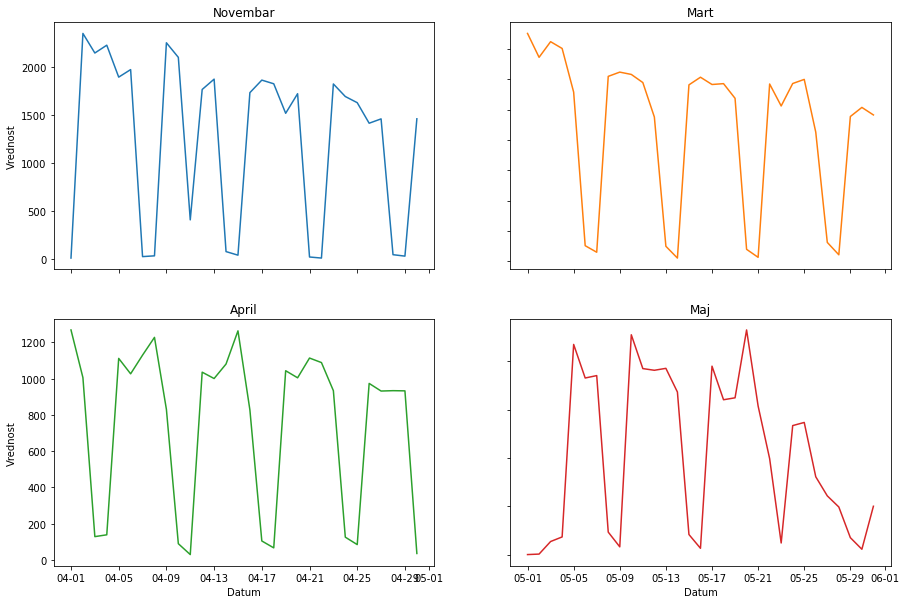

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(15,10))
date_form = DateFormatter("%m-%d")


axs[0, 0].plot(meetings_per_day_november.index, meetings_per_day_november.values)
axs[0, 0].set_title('Novembar')
axs[0, 1].plot(meetings_per_day_march.index, meetings_per_day_march.values, 'tab:orange')
axs[0, 1].set_title('Mart')
axs[1, 0].plot(meetings_per_day_april.index, meetings_per_day_april.values, 'tab:green')
axs[1, 0].set_title('April')
axs[1, 0].xaxis.set_major_formatter(date_form)
axs[1, 1].plot(meetings_per_day_may.index, meetings_per_day_may.values, 'tab:red')
axs[1, 1].set_title('Maj')
axs[1, 1].xaxis.set_major_formatter(date_form)


for ax in axs.flat:
    ax.set(xlabel='Datum', ylabel='Vrednost')

for ax in axs.flat:
    ax.label_outer()

Prosecna duzina trajanja sastanaka svaki dan 

In [15]:
#duration_april = april.groupby(['JOIN_DATE']).DURATION.mean()
#plot_df(duration_april, duration_april.index, duration_april.values, title='trajanje april')

In [16]:
#df['Year'] = april.index.year
#df['Month'] = april.index.month
#df['Weekday Name'] = april.index.day_name()

#april.sample(5, random_state=2)

### Stationarity

Vremenska serija je stacionarna ako:
- ima konstantnu srednju vrednost
- ima konstantnu varijansu
- nema sezonsku komponentu

In [79]:
def check_mean(df, name):
    days = df.shape[0]
    one = days//3
    two = 2*days//3

    print(name + ': ')
    print('Prva trecina: {}'.format(df[:one].values.mean()))
    print('Druga trecina: {}'.format(df[one:two].values.mean()))
    print('Treca trecina: {}'.format(df[two:].values.mean()))
    print('Srednja vrednost na celom skupu: {}\n'.format(df.values.mean()))

In [80]:
check_mean(meetings_per_day_november, 'NOVEMBAR')
check_mean(meetings_per_day_march, 'MART')
check_mean(meetings_per_day_april, 'APRIL')
check_mean(meetings_per_day_may, 'MAJ')

NOVEMBAR: 
Prva trecina: 1498.3
Druga trecina: 1280.8
Treca trecina: 958.2
Srednja vrednost na celom skupu: 1245.7666666666667

MART: 
Prva trecina: 1334.2
Druga trecina: 1014.4
Treca trecina: 970.5454545454545
Srednja vrednost na celom skupu: 1102.0

APRIL: 
Prva trecina: 795.1
Druga trecina: 745.1
Treca trecina: 714.7
Srednja vrednost na celom skupu: 751.6333333333333

MAJ: 
Prva trecina: 350.6
Druga trecina: 608.6
Treca trecina: 290.45454545454544
Srednja vrednost na celom skupu: 412.48387096774195



 Srednja vrednost je uglavnom konstantna, ali se iz grafika vidi da postoji sezonska komponenta (ponavlja se neki sablon) -> nije stacionarna

### Spajanje u jednu vremensku seriju 

In [19]:
ts = pd.concat([meetings_per_day_november, meetings_per_day_march, meetings_per_day_april, meetings_per_day_may])

In [20]:
ts.shape

(122, 1)

122 dana 

In [21]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 122 entries, 2020-11-01 to 2021-05-31
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Meeting_count  122 non-null    int64
dtypes: int64(1)
memory usage: 1.9 KB


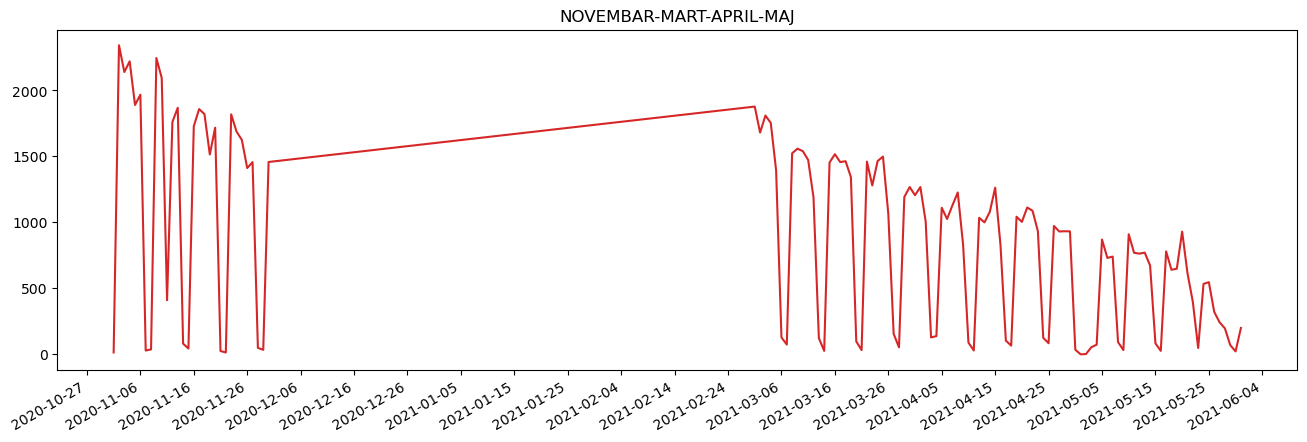

In [22]:
fig = plt.figure(figsize=(16,5), dpi=100)
ax = fig.add_subplot(111)
ax.plot(ts.index, ts.values, 'tab:red')
fig.autofmt_xdate()
plt.title('NOVEMBAR-MART-APRIL-MAJ')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.show()

Posto fali 3 meseca - vremenski period nije u kontinuitetu, moraju da postoje jednaki vremenski razmaci izmedju svake dve tacke ->  izbacujem novembar:

In [23]:
ts_mam = pd.concat([meetings_per_day_march, meetings_per_day_april, meetings_per_day_may])

ts_mam.describe()

,Meeting_count
count,92.000000
mean,755.413043
std,561.664934
min,0.000000
25%,124.500000
50%,828.500000
75%,1196.250000
max,1878.000000


92 dana

In [24]:
ts_mam.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 92 entries, 2021-03-01 to 2021-05-31
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Meeting_count  92 non-null     int64
dtypes: int64(1)
memory usage: 1.4 KB


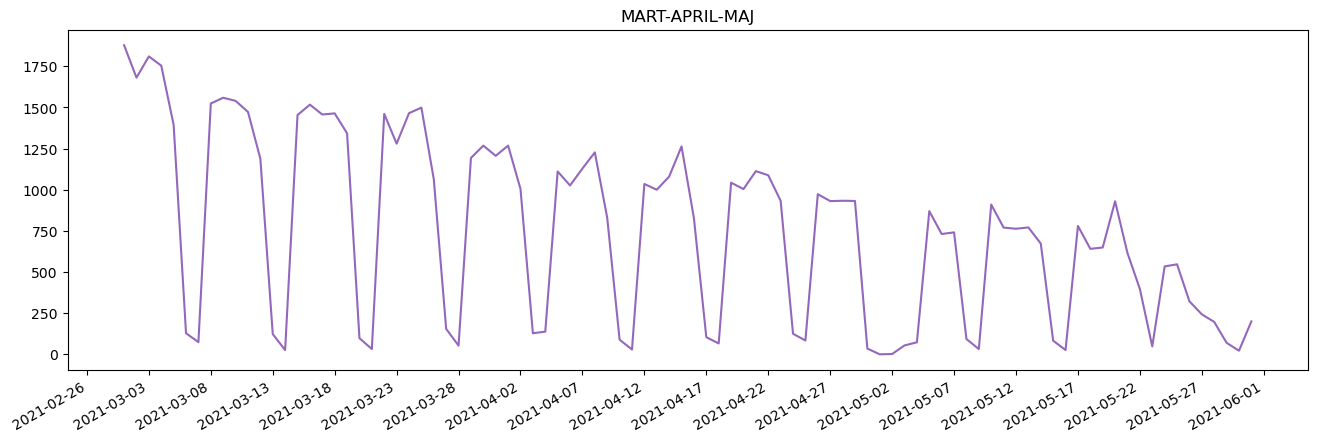

In [25]:
fig = plt.figure(figsize=(16,5), dpi=100)
ax = fig.add_subplot(111)
ax.plot(ts_mam.index, ts_mam.values, 'tab:purple')
fig.autofmt_xdate()
plt.title('MART-APRIL-MAJ')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.show()

In [89]:
# ako hocu samo radne dane:
# ts_mam = ts_mam.asfreq('b')

## QQ plot

In [60]:

array = ts_mam.values.flatten()
ts_mam['Meeting_count'] = array
ts_mam['Meeting_count']

Date
2021-03-01    1878
2021-03-02    1681
2021-03-03    1810
2021-03-04    1754
2021-03-05    1394
              ... 
2021-05-27     243
2021-05-28     197
2021-05-29      70
2021-05-30      22
2021-05-31     200
Name: Meeting_count, Length: 92, dtype: int64

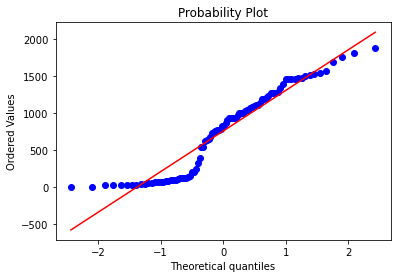

In [61]:
scipy.stats.probplot(ts_mam['Meeting_count'], plot=pylab)
pylab.show()

- RED LINE = what the data points should follow if they are **normally distributed**

- X-axis = Theoretical quantiles -> How many standard deviations away from the mean these values are

Zakljucak: podaci nemaju normalnu raspodelu

## Stationarity

In [219]:
#check_mean(ts, 'NOVEMBAR-MART-APRIL-MAJ')

Srednja vrednost nije konstantna --> nije stacionarna

In [81]:
check_mean(ts_mam, 'MART-APRIL-MAJ')

MART-APRIL-MAJ: 
Prva trecina: 1098.5333333333333
Druga trecina: 766.2903225806451
Treca trecina: 412.48387096774195
Srednja vrednost na celom skupu: 755.4130434782609



## DF test

- $H_0$ - Serija nije stacionarna
- $H_1$ - Serija je stacionarna

- p-vrednost - ako je manje od kriticne vrednosti na 1%, 5% i 10%, odbija se $H_0$ i zakljucak je da je stacionarna

In [146]:
test = sts.adfuller(ts_mam)

print(f"ADF test statistic: {test[0]}")
print(f"p-value: {test[1]}")
print("Critical thresholds:")
for key, value in test[4].items():
    print(f"\t{key}: {value}")

ADF test statistic: -0.8542426689597318
p-value: 0.8026674415557367
Critical thresholds:
	1%: -3.512738056978279
	5%: -2.8974898650628984
	10%: -2.585948732897085


1. tsa statistika  = -0.8 je veca od svih procenata -> nema dokaza stacionarnosti
2. p- vrednost =  0.802 -> 0.8 sanse da prohvatim hipotezu $H_0$ (da je nestacionarna)
3. broj lagova = 9
4. broj opservacija koriscenih u analiizi = 82
5. maximized information criteria = 1095.4012

Sto su nize vrednosti, lakse se predvidja 

Odavde je zakljucak da serija nije stacionarna i da postoji autokorelacija


## Dekompozicija

Simply put, time series decomposition is a process of deconstructing a time series into the following components:

- Trend — general movement over time (pattern)
- Seasonal — behaviors captured in individual seasonal periods (cyclical effects)
- Residual — everything not captured by trend and seasonal components (error of prediction)

There are two techniques for combining time series components:

- Additive
- Multiplicative

We care about these because time series decomposition requires you to specify a model type for the seasonal component. The default is additive, but you can easily change that.

The term additive means individual components (trend, seasonality, and residual) are added together:
An additive trend indicates a linear trend, and an additive seasonality indicates the same frequency (width) and amplitude (height) of seasonal cycles.

In [97]:
def decompose(data):
    res = seasonal_decompose(data, model = "additive")
    
    fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(10,8))
    res.observed.plot(ax=ax1, ylabel = "observed")
    res.trend.plot(ax=ax2,ylabel = "trend")
    res.resid.plot(ax=ax3,ylabel = "seasoanlity")
    res.seasonal.plot(ax=ax4,ylabel = "residual")
    plt.tight_layout()
    plt.show()
    return res

In [98]:
#decompose(ts)

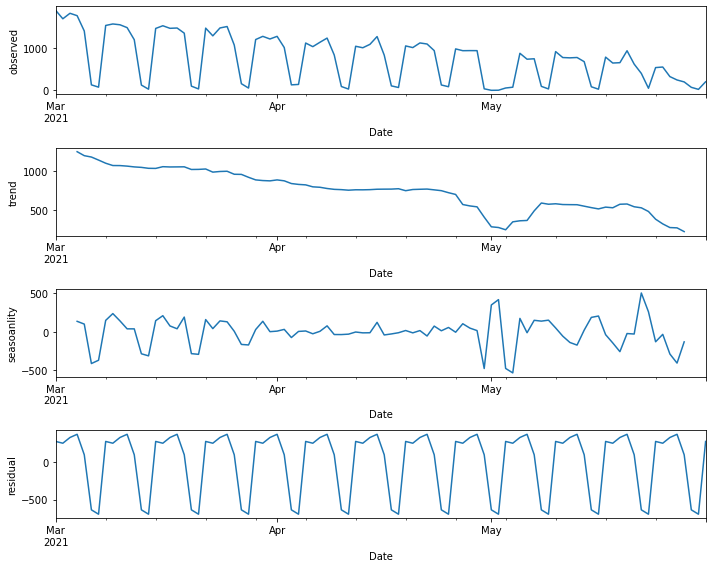

In [143]:
decomposed = decompose(ts_mam)

## Autokorelacija

Korelacija sa samim sobom - sa sekvencom sa zakasnjenjem => koliko su jucerasnji podaci slicni danasnjim


So when performing ACF it is advisable to remove any trend present in the data and to make sure the data is stationary.

### Pretvaranje u stacionarnu

In [147]:
ts_mam['diff1'] = ts_mam['Meeting_count'].diff(periods=1)
ts_mam['diff2'] = ts_mam['Meeting_count'].diff(periods=2)
ts_mam['diff3'] = ts_mam['Meeting_count'].diff(periods=3)

In [149]:
ts_mam.head()

,Meeting_count,diff1,diff2,diff3
Date,,,,
2021-03-01,1878,NaN,NaN,NaN
2021-03-02,1681,-197.0,NaN,NaN
2021-03-03,1810,129.0,-68.0,NaN
2021-03-04,1754,-56.0,73.0,-124.0
2021-03-05,1394,-360.0,-416.0,-287.0


In [150]:
#plt.figure(figsize=(10, 5))
#diff_mam = np.diff(ts_mam['Meeting_count'])
#plt.plot(ts_mam.index[:-1], diff_mam)
#plt.title('Uklonjen trend')
#plt.show()

Provera stacionarnosti:

In [155]:
res = sts.adfuller(ts_mam['diff2'].dropna())

print(f"ADF test statistic: {res[0]}")
print(f"p-value: {res[1]}")
print("Critical thresholds:")
for key, value in res[4].items():
    print(f"\t{key}: {value}")

ADF test statistic: -3.465573983425202
p-value: 0.008916516976169053
Critical thresholds:
	1%: -3.518281134660583
	5%: -2.899878185191432
	10%: -2.5872229937594873


p vrednost je skoro 0 -> stacionarna kad se dva puta diferencira

Potrebno ukloniti nelinearni trend:

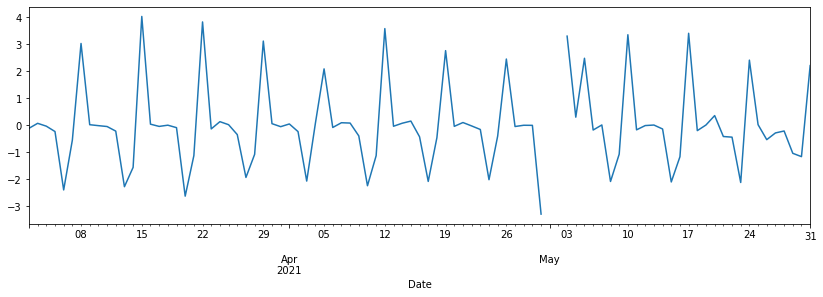

In [158]:
ts_transformed = pd.Series(np.log(ts_mam['Meeting_count'])).diff().dropna()
ts_transformed.plot(figsize=(14,4))
plt.show()

In [172]:
ts_transformed.isin([np.nan, np.inf, -np.inf]).sum()
ts_transformed = ts_transformed.replace([np.inf, -np.inf], np.nan).dropna()
ts_transformed.isin([np.nan, np.inf, -np.inf]).sum()

0

In [173]:
results = sts.adfuller(ts_transformed)

In [174]:
results[1]

0.029348303200585766

We will focus on the points that lie beyond the blue region as they signify strong statistical significance.

In [107]:
#sgt.plot_acf(diff_mam, lags=40, zero=False)
#plt.show()

40 lagova je dovoljno (dogovor), zero = false jer ce tu svakako biti 1 (sa samim sobom)

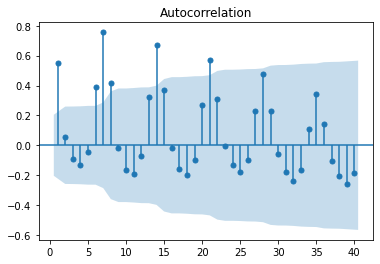

In [103]:
sgt.plot_acf(ts_mam, lags=40, zero=False)
plt.show()

Kako vreme odmice sve je manja korelacija`

## PACF - Partial Autocorrelation function

Pokazuje samo direktan efekat

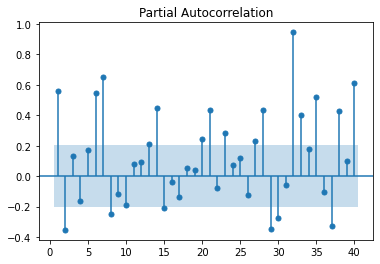

In [110]:
sgt.plot_pacf(ts_mam, lags=40, zero=False, method=('ols'))
plt.show()

npr. treci lag je negativno korelisan -> znaci da manje vrednosti pre tri perioda znace vece vrednosti na danasnji dan

## Podela na trening i test

Obicno je podela 80% - 20% 

In [111]:
# probacu sa 70-30

size = int(len(ts_mam)*0.7)

In [112]:
df_train = ts_mam.iloc[:size]
df_train.tail()

,Meeting_count
Date,
2021-04-29,932
2021-04-30,35
2021-05-01,0
2021-05-02,2
2021-05-03,54


In [113]:
df_test = ts_mam.iloc[size:]
df_test.head()

,Meeting_count
Date,
2021-05-04,73
2021-05-05,870
2021-05-06,731
2021-05-07,741
2021-05-08,93


## Izbor modela

AR MODEL - oslanja se na prethodne periode; linearni model, u kom su trenutne vrednosti suma prethodnih pomnozena nekim numerickim faktorom
- $X_{t}$ = trenutna vrednost (danas)

- $X_{t-1}$ = prosla vrednost (juce)


Model : $X_{t} = C + \phi * X_{t-1} + \epsilon_{t}$

- $\phi$ je izmedju -1 i 1
- $\epsilon_{t}$ je rezidual - razlika izmedju predvidjene vrednosti u trenutku t i tacne vrednosti

Koliko lagova koristiti?

Sto vise lagova -> komplikovaniji model -> vise koeficijenata -> veca verovatnoca da neki budu beznacajni

Broj lagova odredjujemo na osnovu ACF i PACF

In [119]:
model_ar = ARMA(df_train, order=(1,0))
# 1 lag

In [117]:
results_ar = model_ar.fit()

In [118]:
results_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:          Meeting_count   No. Observations:                   64
Model:                     ARMA(1, 0)   Log Likelihood                -489.353
Method:                       css-mle   S.D. of innovations            505.048
Date:                Sat, 04 Sep 2021   AIC                            984.707
Time:                        18:34:41   BIC                            991.184
Sample:                    03-01-2021   HQIC                           987.258
                         - 05-03-2021                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 889.6832    131.540      6.764      0.000     631.870    1147.497
ar.L1.Meeting_count     0.5282      0.110      4.817      0.000       0.313       0.743
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.8931           +0.0000j            1.8931            0.0000
-----------------------------------------------------------------------------
"""

- coef = 889.6832 -> C
- coef = 0.5282 -> $\phi$

- std err = 131.540 i 0.110 -> koliko su u proseku predikcije razlicite od stvarnih vrednosti


In [134]:
#model_ar2 = ARMA(df_train, order=(2,0))
# 2 laga 

#results_ar2 = model_ar2.fit()
#results_ar2.summary()

In [135]:
#model_ar3 = ARMA(df_train, order=(3,0))
# 3 laga 

#results_ar3 = model_ar3.fit()
#results_ar3.summary()

In [136]:
#model_ar4 = ARMA(df_train, order=(4,0))
# 3 laga 

#results_ar4 = model_ar4.fit()
#results_ar4.summary()

## LLR TEST - poredjenje modela

In [125]:
def llr_test(mod_1, mod_2, df=1):
    l1 = mod_1.fit().llf
    l2 = mod_2.fit().llf
    lr = (2*(l2-l1))
    
    p = chi2.sf(lr, df).round(3)
    
    return p

In [126]:
#llr_test(model_ar2, model_ar3)

0.681

In [127]:
#llr_test(model_ar3, model_ar4)

0.003

In [137]:
#print(results_ar4.summary())
#print('LLR test p-value= ' + str(llr_test(model_ar3, model_ar4)))

In [138]:
#model_ar5 = ARMA(df_train, order=(5,0))
# 5 laga 

#results_ar5 = model_ar5.fit()
#print(results_ar5.summary())
#print('LLR test p-value= ' + str(llr_test(model_ar4, model_ar5)))

In [139]:
#model_ar6 = ARMA(df_train, order=(6,0))
# 6 laga 

#results_ar6 = model_ar6.fit()
#print(results_ar6.summary())
#print('LLR test p-value= ' + str(llr_test(model_ar5, model_ar6)))

In [141]:
model_ar7 = ARMA(df_train, order=(7,0))
# 7 laga 

results_ar7 = model_ar7.fit()
print(results_ar7.summary())
#print('LLR test p-value= ' + str(llr_test(model_ar6, model_ar7)))

                              ARMA Model Results                              
Dep. Variable:          Meeting_count   No. Observations:                   64
Model:                     ARMA(7, 0)   Log Likelihood                -442.065
Method:                       css-mle   S.D. of innovations            202.241
Date:                Sat, 04 Sep 2021   AIC                            902.130
Time:                        19:04:37   BIC                            921.560
Sample:                    03-01-2021   HQIC                           909.785
                         - 05-03-2021                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 886.7424        nan        nan        nan         nan         nan
ar.L1.Meeting_count     0.1971   3.43e-06   5.74e+04      0.000       0.197       0.197
ar.L2.Meeting_co

In [133]:
print('LLR test: ' + str(llr_test(model_ar, model_ar7, df = 6)))

LLR test: 0.0


Stajemo na 7

AR model nije dobar za predvidjanje nestacionarnih podataka

In [175]:
model_tr = ARMA(ts_transformed, order=(7,0))

In [178]:
rez = model_tr.fit()

In [179]:
rez.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:          Meeting_count   No. Observations:                   89
Model:                     ARMA(7, 0)   Log Likelihood                -106.959
Method:                       css-mle   S.D. of innovations              0.774
Date:                Sat, 04 Sep 2021   AIC                            231.919
Time:                        19:55:23   BIC                            254.316
Sample:                             0   HQIC                           240.947
                                                                              
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0101      0.030      0.338      0.736      -0.048       0.069
ar.L1.Meeting_count    -0.4083      0.093     -4.408      0.000      -0.590      -0.227
ar.L2.Meeting_count    -0.4477      0.099     -4.538      0.000      -0.641      -0.254
ar.L3.Meeting_count    -0.3962      0.103     -3.834      0.000      -0.599      -0.194
ar.L4.Meeting_count    -0.3811      0.103     -3.713      0.000      -0.582      -0.180
ar.L5.Meeting_count    -0.3668      0.102     -3.584      0.000      -0.567      -0.166
ar.L6.Meeting_count    -0.2829      0.099     -2.850      0.004      -0.477      -0.088
ar.L7.Meeting_count     0.4808      0.093      5.146      0.000       0.298       0.664
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.9442           -0.4552j            1.0482           -0.4285
AR.2           -0.9442           +0.4552j            1.0482            0.4285
AR.3           -0.2392           -0.9973j            1.0256           -0.2875
AR.4           -0.2392           +0.9973j            1.0256            0.2875
AR.5            0.6205           -0.8155j            1.0247           -0.1465
AR.6            0.6205           +0.8155j            1.0247            0.1465
AR.7            1.7141           -0.0000j            1.7141           -0.0000
-----------------------------------------------------------------------------
"""